In [ ]:
import sys, subprocess, importlib, os, json, zipfile, pathlib

if sys.version_info >= (3,13):
    raise RuntimeError(
        f"Este notebook necesita Python <= 3.12 para usar PyCaret. "
        f"Estás en {sys.version.split()[0]}. Cambiá el kernel a Python 3.11/3.12."
    )

def ensure(pkg):
    if importlib.util.find_spec(pkg) is None:
        print(f"📦 Instalando {pkg} en {sys.executable} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "pip", "setuptools", "wheel"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
    else:
        print(f"✅ {pkg} ya está instalado.")

for dep in ["kaggle", "pycaret"]:
    ensure(dep)
    
######################################################################################################################
# CONECTAR CON KAGGLE
######################################################################################################################
    
from kaggle.api.kaggle_api_extended import KaggleApi

# Validar token
home = pathlib.Path.home()
kaggle_dir = home / ".kaggle"
kaggle_json = kaggle_dir / "kaggle.json"
if not kaggle_json.exists():
    raise RuntimeError(
        f"Error con el archivo .JSON"
    )

# Autenticación
os.environ["KAGGLE_CONFIG_DIR"] = str(kaggle_dir)
api = KaggleApi()
api.authenticate()

# Competencia
COMP = "house-prices-advanced-regression-techniques"


# Chequear listar archivos (test de permisos)
resp = api.competition_list_files(COMP)

# Normalizar a lista de items
items = getattr(resp, "files", resp)

# Obtener nombres
names = []
for f in items:
    name = getattr(f, "name", None)
    if not name:
        name = getattr(f, "fileName", None)
    if not name:
        name = str(f)
    names.append(name)

print("Archivos disponibles en la competencia:", names)

# Descargar a data/kaggle
dest = pathlib.Path("data/kaggle")
dest.mkdir(parents=True, exist_ok=True)
api.competition_download_files(COMP, path=str(dest), force=True, quiet=False)

# Descomprimir cualquier ZIP
for z in dest.glob("*.zip"):
    print(f"Descomprimiendo {z.name}...")
    with zipfile.ZipFile(z, "r") as zip_ref:
        zip_ref.extractall(dest)

print(f"✅ Listo. Archivos en: {dest.resolve()}")

print("✅ Entorno listo.")


✅ kaggle ya está instalado.
✅ pycaret ya está instalado.
Archivos disponibles en la competencia: ['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']


100%|██████████| 199k/199k [00:00<00:00, 48.3MB/s]


Descomprimiendo house-prices-advanced-regression-techniques.zip...
✅ Listo. Archivos en: C:\Users\lesanmartin\Desktop\Python\data\kaggle
✅ Entorno listo.


In [14]:
from pycaret.regression import *

In [15]:
from pycaret.datasets import get_data

In [17]:
import pandas as pd
import pathlib

# Ruta base donde se descargaron los datos
base_path = pathlib.Path("data/kaggle")

# Verificar que existan los archivos
train_file = base_path / "train.csv"
test_file = base_path / "test.csv"

if not train_file.exists() or not test_file.exists():
    raise FileNotFoundError(f"No se encontraron train.csv o test.csv en {base_path.resolve()}")

# Mostrar opciones
print("📊 Archivos disponibles:")
print("1️⃣ train.csv")
print("2️⃣ test.csv")
choice = input("👉 Elegí el número del archivo que querés usar (1 o 2): ").strip()

if choice == "1":
    selected_file = train_file
elif choice == "2":
    selected_file = test_file
else:
    raise ValueError("Opción inválida. Elegí 1 o 2.")

# Cargar dataset
df = pd.read_csv(selected_file)
print(f"\n✅ Archivo seleccionado: {selected_file.name}")
print(f"📏 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas\n")

# Mostrar las primeras filas
display(df.head())


📊 Archivos disponibles:
1️⃣ train.csv
2️⃣ test.csv

✅ Archivo seleccionado: train.csv
📏 Dimensiones: 1460 filas × 81 columnas



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [19]:
exp = setup(data=df, numeric_imputation='median', target='SalePrice', session_id=9999)

,Description,Value
0,Session id,9999
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 81)"
4,Transformed data shape,"(1460, 281)"
5,Transformed train set shape,"(1021, 281)"
6,Transformed test set shape,"(439, 281)"
7,Numeric features,37
8,Categorical features,43
9,Rows with missing values,100.0%


In [20]:
best_model = compare_models()

In [22]:
print("Best model is: ", best_model)

Best model is:  GradientBoostingRegressor(random_state=9999)


In [23]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14421.7832,474559847.6590,21784.3946,0.9051,0.1071,0.0787
1,17122.1552,1003417918.1941,31676.7725,0.8877,0.1160,0.0820
2,14683.2215,504105514.0981,22452.2942,0.9239,0.1303,0.0918
3,16326.4671,683699941.8569,26147.6565,0.8774,0.1235,0.0887
4,15793.8014,495376976.0960,22257.0658,0.9004,0.1160,0.0855
5,19596.9846,2723119847.2191,52183.5208,0.5969,0.1816,0.1168
6,17634.6471,801802262.9326,28316.1131,0.8714,0.1633,0.1109
7,17260.1810,852415151.5218,29196.1496,0.8472,0.1370,0.0974
8,17278.4054,836253873.6660,28918.0545,0.8902,0.1473,0.1000


In [24]:
tuned_model = tune_model(gbr)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:49:45
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15410.8329,495551393.5736,22260.9837,0.9009,0.1149,0.0895
1,19886.6061,1303591432.6206,36105.2826,0.8541,0.1316,0.0970
2,16336.0517,545788175.7722,23362.1098,0.9176,0.1391,0.1035
3,17596.5089,756637626.4101,27507.0469,0.8643,0.1317,0.0947
4,18494.5934,607311996.1718,24643.7009,0.8779,0.1351,0.1022
5,20245.7525,2082546147.8038,45634.9225,0.6917,0.1825,0.1228
6,19113.5201,886661019.4401,29776.8538,0.8578,0.1671,0.1180
7,20025.3888,1039396112.0104,32239.6667,0.8137,0.1467,0.1136
8,17708.6207,959691854.3948,30978.8937,0.8740,0.1470,0.1001


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


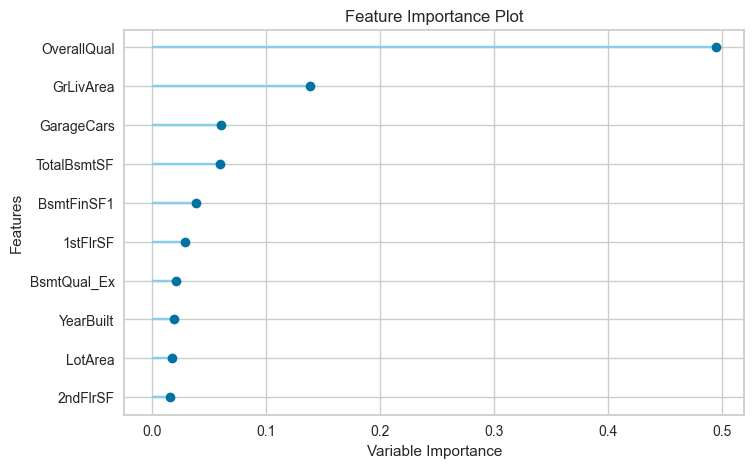

In [25]:
plot_model(tuned_model, plot='feature')

In [26]:
predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,15698.0774,844146106.2308,29054.1926,0.8680,0.1415,0.0993


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,prediction_label
957,958,20,RL,70.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2007,WD,Normal,132000,135812.704005
784,785,75,RM,35.0,6300,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,6,2008,WD,Normal,128000,139662.601290
192,193,20,RL,68.0,9017,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2009,WD,Normal,192000,199437.118163
607,608,20,RL,78.0,7800,Pave,NaN,Reg,Bnk,AllPub,...,NaN,NaN,NaN,0,8,2006,WD,Normal,225000,166475.109666
90,91,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,WD,Normal,109900,106015.949990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,211,30,RL,67.0,5604,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,4,2008,WD,Normal,98000,99115.716841
815,816,20,RL,48.0,12137,Pave,NaN,IR2,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2010,WD,Normal,224900,207612.869663
669,670,30,RL,80.0,11600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,7,2006,WD,Normal,137500,116382.494019
62,63,120,RL,44.0,6442,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,10,2007,WD,Normal,202500,218557.722435


In [27]:
final_model = finalize_model(tuned_model)

In [28]:
print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                             'LotArea', 'OverallQual',
                                             'OverallCond', 'YearBuilt',
                                             'YearRemodAdd', 'MasVnrArea',
                                             'BsmtFinSF1', 'BsmtFinSF2',
                                             'BsmtUnfSF', 'TotalBsmtSF',
                                             '1stFlrSF', '2ndFlrSF',
                                             'LowQualFinSF', 'GrLivArea',
                                             'BsmtFullBath', 'BsmtHalfBath',
                                             'FullBath', 'Hal...
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                           

In [29]:
save_model(final_model,'final_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Id', 'MSSubClass', 'LotFrontage',
                                              'LotArea', 'OverallQual',
                                              'OverallCond', 'YearBuilt',
                                              'YearRemodAdd', 'MasVnrArea',
                                              'BsmtFinSF1', 'BsmtFinSF2',
                                              'BsmtUnfSF', 'TotalBsmtSF',
                                              '1stFlrSF', '2ndFlrSF',
                                              'LowQualFinSF', 'GrLivArea',
                                              'BsmtFullBath', 'BsmtHalfBath',
                                              'FullBath', 'Hal...
                                                                     'Exterior1st',
                                                                     'Exterior2nd',
             

In [31]:
# === Generar payload JSON desde train.csv ===
import numpy as np
import pathlib

# Ruta del dataset
train_path = pathlib.Path("data/kaggle/train.csv")

# Verificamos exista
if not train_path.exists():
    raise FileNotFoundError(f"No se encontró el archivo {train_path.resolve()}")

# Cargar dataset
houses_ds_train = pd.read_csv(train_path)
print(f"✅ Dataset cargado: {train_path.name}")
print(f"📏 Filas: {houses_ds_train.shape[0]}  |  Columnas: {houses_ds_train.shape[1]}")

fila = 0 

# Tomar el registro y preparar JSON
record = houses_ds_train.iloc[fila].to_dict()

# Si el target está presente se elimina
record.pop("SalePrice", None)

# Reemplazar NaN por None para JSON válido
clean_record = {k: (None if pd.isna(v) else v) for k, v in record.items()}

# Generar el payload final
payload = json.dumps([clean_record], ensure_ascii=False)

print("\n✅ Payload generado correctamente:")
print(payload)



✅ Dataset cargado: train.csv
📏 Filas: 1460  |  Columnas: 81

✅ Payload generado correctamente:
[{"Id": 1, "MSSubClass": 60, "MSZoning": "RL", "LotFrontage": 65.0, "LotArea": 8450, "Street": "Pave", "Alley": null, "LotShape": "Reg", "LandContour": "Lvl", "Utilities": "AllPub", "LotConfig": "Inside", "LandSlope": "Gtl", "Neighborhood": "CollgCr", "Condition1": "Norm", "Condition2": "Norm", "BldgType": "1Fam", "HouseStyle": "2Story", "OverallQual": 7, "OverallCond": 5, "YearBuilt": 2003, "YearRemodAdd": 2003, "RoofStyle": "Gable", "RoofMatl": "CompShg", "Exterior1st": "VinylSd", "Exterior2nd": "VinylSd", "MasVnrType": "BrkFace", "MasVnrArea": 196.0, "ExterQual": "Gd", "ExterCond": "TA", "Foundation": "PConc", "BsmtQual": "Gd", "BsmtCond": "TA", "BsmtExposure": "No", "BsmtFinType1": "GLQ", "BsmtFinSF1": 706, "BsmtFinType2": "Unf", "BsmtFinSF2": 0, "BsmtUnfSF": 150, "TotalBsmtSF": 856, "Heating": "GasA", "HeatingQC": "Ex", "CentralAir": "Y", "Electrical": "SBrkr", "1stFlrSF": 856, "2ndFlrSF